In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader as web
import datetime as dt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential


In [36]:
crypto_currency = 'BTC'
against_currency = 'USD'

start = dt.datetime(2016, 1, 1)
end = dt.datetime.now()

data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', start, end)

Prepare Data

In [37]:
print(data.head())

                  High         Low        Open       Close    Volume  \
Date                                                                   
2016-01-01  436.246002  427.515015  430.721008  434.334015  36278900   
2016-01-02  436.062012  431.869995  434.622009  433.437988  30096600   
2016-01-03  433.743011  424.705994  433.578003  430.010986  39633800   
2016-01-04  434.516998  429.084015  430.061005  433.091003  38477500   
2016-01-05  434.182007  429.675995  433.069000  431.959991  34522600   

             Adj Close  
Date                    
2016-01-01  434.334015  
2016-01-02  433.437988  
2016-01-03  430.010986  
2016-01-04  433.091003  
2016-01-05  431.959991  


In [38]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

In [39]:
prediction_days = 60
future_day = 30

x_train, y_train = [], []

for x in range (prediction_days, len(scaled_data)-future_day):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x+future_day, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

Neural Network

In [40]:
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer = 'adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)



Epoch 1/25
69/69 [==============================] - 14s 126ms/step - loss: 0.0097
Epoch 2/25
69/69 [==============================] - 10s 142ms/step - loss: 0.0028
Epoch 3/25
69/69 [==============================] - 9s 134ms/step - loss: 0.0024
Epoch 4/25
69/69 [==============================] - 8s 123ms/step - loss: 0.0022
Epoch 5/25
69/69 [==============================] - 9s 130ms/step - loss: 0.0020
Epoch 6/25
69/69 [==============================] - 10s 141ms/step - loss: 0.0020
Epoch 7/25
69/69 [==============================] - 10s 138ms/step - loss: 0.0020
Epoch 8/25
69/69 [==============================] - 9s 129ms/step - loss: 0.0017
Epoch 9/25
69/69 [==============================] - 10s 144ms/step - loss: 0.0021
Epoch 10/25
69/69 [==============================] - 10s 142ms/step - loss: 0.0017
Epoch 11/25
69/69 [==============================] - 11s 155ms/step - loss: 0.0017
Epoch 12/25
69/69 [==============================] - 9s 126ms/step - loss: 0.0018
Epoch 13/25
69/69 

Testing Model

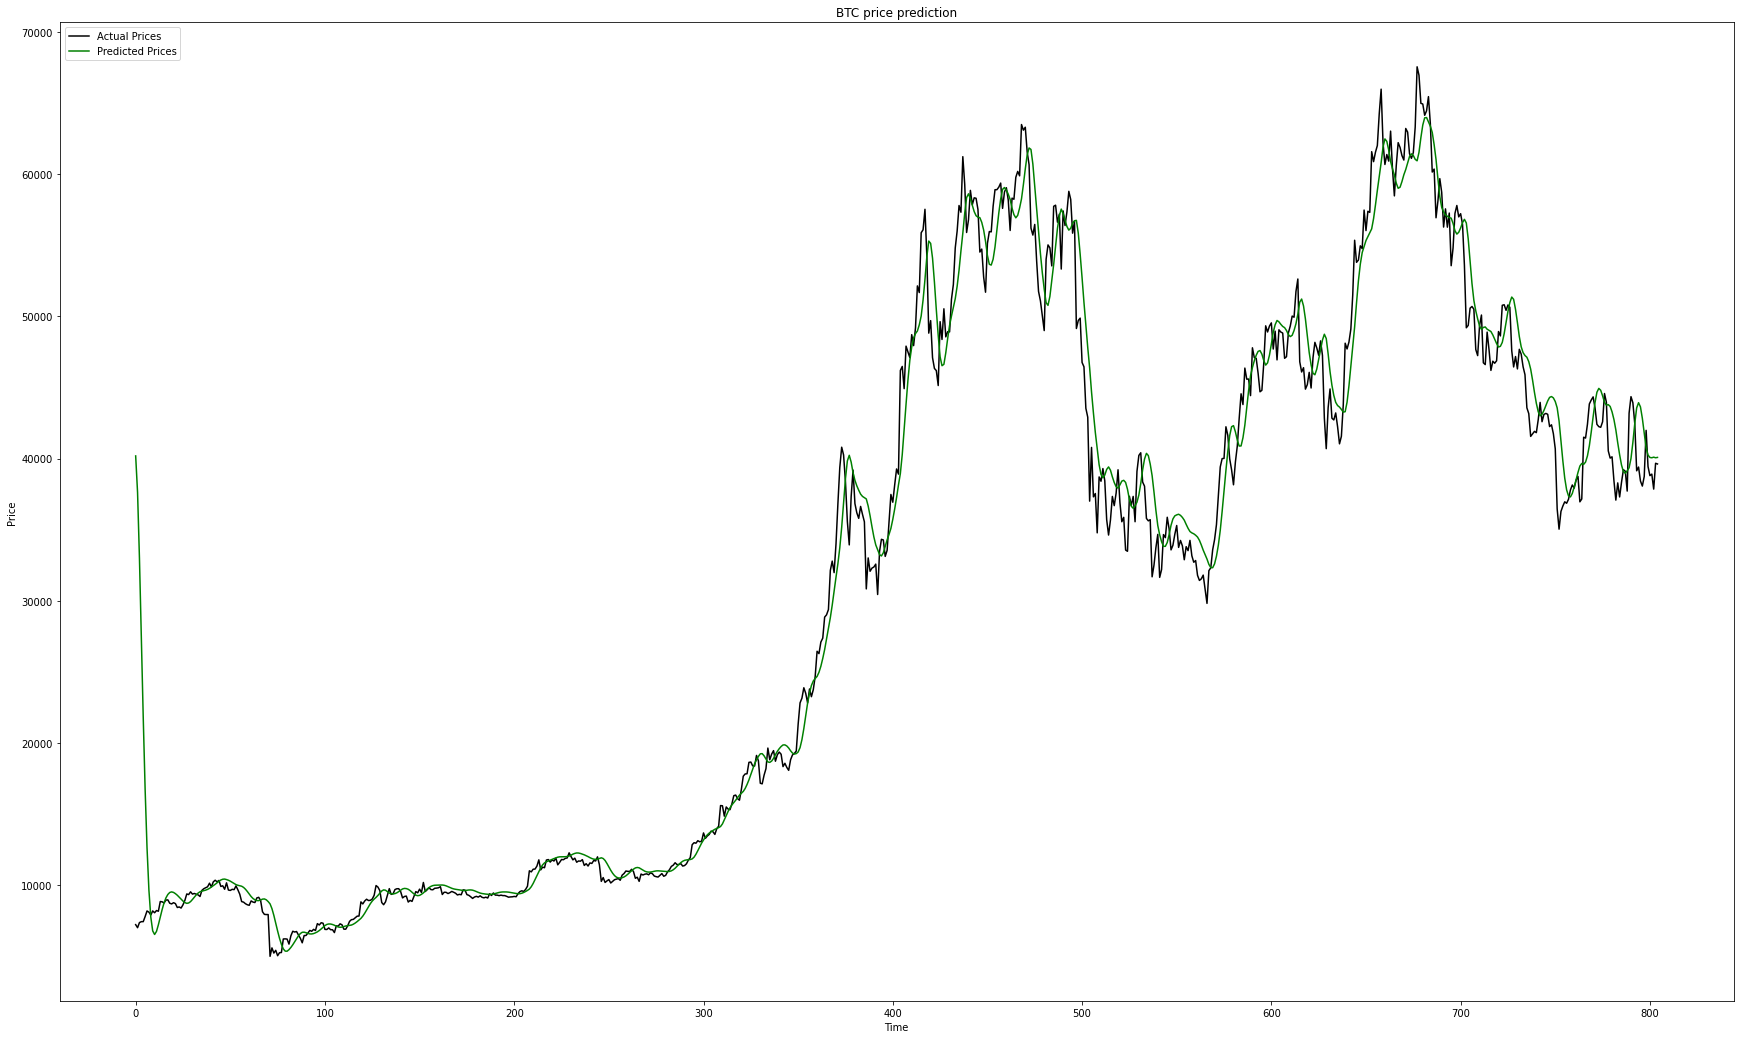

In [41]:
test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data = web.DataReader(f'{crypto_currency}-{against_currency}', 'yahoo', test_start, test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis = 0)
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.fit_transform(model_inputs)

x_test = []

for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x,0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

prediction_prices = model.predict(x_test)
prediction_prices = scaler.inverse_transform(prediction_prices)

plt.rcParams['figure.figsize'] = (30,18)
plt.plot(actual_prices, color='black', label='Actual Prices')
plt.plot(prediction_prices, color='green', label='Predicted Prices')
plt.title(f'{crypto_currency} price prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()